# FRGC Clustering with RetinaFace + ArcFace

## 0. Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from insightface.app import FaceAnalysis
from tqdm import tqdm
import pandas as pd
from joblib import Parallel, delayed

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' #use both GPU

## 1. Load FRGC dataset

In [4]:
FRGC_root = '/d1/jferna27/FRGC-nd1/all'
csv_path = '../frgc cluster/frgc_face_embeddings.csv'

if os.path.exists(csv_path): # CSV found, load from it
    print(f"Found {csv_path}, person ids loaded from csv")
    df = pd.read_csv(csv_path) #df.columns: 512d, label,image_file,, person_id
    image_files = df['image_file'].tolist()
    print(f"Total images: {len(image_files)}")
    person_ids = [p[:5] for p in image_files] #person id (1st 5 characters)
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    labels = df['label'].values

else: # CSV not found, use FRGC_root directory scan
    image_files = [f for f in os.listdir(FRGC_root) if f.endswith('.JPG') or f.endswith('.jpg')]
    print(f"Total images: {len(image_files)}")
    person_ids = [img[:5] for img in image_files] #person id (1st 5 characters)
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    person_to_label = {person: idx for idx, person in enumerate(unique_persons)} #mapping from person_id to label index
    labels = np.array([person_to_label[pid] for pid in person_ids])

Found ../frgc cluster/frgc_face_embeddings.csv, person ids loaded from csv
Total images: 39327
Identities: 568


## 2. Initialize Face Detection + Embeddings

## 3. Extract embeddings (parallel processing on both GPUs)

In [5]:
if os.path.exists(csv_path): #use csv if exists
    print("Found frgc_face_embeddings.csv")
    df = pd.read_csv(csv_path)
    drop_cols = ['label', 'image_file', 'person_id']
    emb_cols = [c for c in df.columns if c not in drop_cols]
    embeddings = df[emb_cols].values
    valid_labels = df['label'].values
    valid_image_files = df['image_file'].tolist()

else: #csv does not exist, process images to extract embeddings
    print(f"Processing with GPU 0 and 1")
    def process_batch_worker(gpu_id, batch_data): #function of detect and embed, but for a specific GPU
        app = FaceAnalysis(name="buffalo_l") #arcface
        app.prepare(ctx_id=gpu_id, det_size=(160, 160)) #160,160 the same as LFW, then it could be 620,620 because FRGC has high-res images
        embs, lbls, files = [], [], []
        for img_file, lbl in tqdm(batch_data, desc=f"GPU {gpu_id}"):
            #detect and extract emb
            img = cv2.imread(os.path.join(FRGC_root, img_file))
            if img is not None:
                faces = app.get(img)
                if len(faces) > 0:
                    embs.append(faces[0].embedding)
                    lbls.append(lbl)
                    files.append(img_file)
        return {'embs': embs, 'lbls': lbls, 'files': files}
    mid = len(image_files) // 2 #split data for 2 GPUs and process in parallel
    results = Parallel(n_jobs=2, backend='loky')(
        delayed(process_batch_worker)(gpu_id, list(zip(image_files[start:end], labels[start:end])))
        for gpu_id, (start, end) in [(0, (0, mid)), (1, (mid, len(image_files)))]
    )
    embeddings = np.vstack([np.array(r['embs']) for r in results])
    valid_labels = np.concatenate([np.array(r['lbls']) for r in results])
    valid_image_files = sum([r['files'] for r in results], [])

print(f"Embeddings: {embeddings.shape}")
print(f"Valid images: {len(valid_image_files)}")
print(f"Unique identities: {len(np.unique(valid_labels))}")

Found frgc_face_embeddings.csv
Embeddings: (39327, 512)
Valid images: 39327
Unique identities: 568


In [6]:
if os.path.exists(csv_path):
    print(f"{csv_path} already exists.")
else: #save csv
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['label'] = valid_labels
    embeddings_df['image_file'] = valid_image_files
    embeddings_df['person_id'] = [img[:5] for img in valid_image_files]
    embeddings_df.to_csv(csv_path, index=False)
    print(f"Embeddings and labels saved to '{csv_path}'")

../frgc cluster/frgc_face_embeddings.csv already exists.


## 4. Cluster by identity

In [7]:
label_values = np.unique(valid_labels)
counts = {lbl: int((valid_labels == lbl).sum()) for lbl in label_values}

#filter identities >=100 images
min_images_threshold = 100
filtered_labels = [lbl for lbl, count in counts.items() if count >= min_images_threshold]
print(f"Total identities before filter: {len(label_values)}")
print(f"Identities with >= {min_images_threshold} images: {len(filtered_labels)}")
counts_filtered = {lbl: counts[lbl] for lbl in filtered_labels}
min_count = min(counts_filtered.values())
print(f"Per-label counts (examples): {list(counts_filtered.items())[:5]} ...")
print(f"Minimum images per identity: {min_count}")

rng = np.random.RandomState(42)
identity_clusters = {}
balanced_indices = []
for lbl in filtered_labels:
    inds = np.where(valid_labels == lbl)[0]
    if len(inds) > min_count:
        sel = rng.choice(inds, size=min_count, replace=False)
    else:
        sel = inds
    sel = np.sort(sel)  # keep deterministic ordering for inspectability
    balanced_indices.extend(list(sel))
    identity_clusters[lbl] = embeddings[sel]

# Balanced arrays (optional -- downstream code can use these if desired)
balanced_indices = np.array(balanced_indices)
balanced_embeddings = embeddings[balanced_indices]
balanced_labels = valid_labels[balanced_indices]
balanced_image_files = [valid_image_files[i] for i in balanced_indices]
print(f"Balanced embeddings shape: {balanced_embeddings.shape}")

Total identities before filter: 568
Identities with >= 100 images: 142
Per-label counts (examples): [(0, 218), (2, 136), (3, 220), (4, 202), (8, 104)] ...
Minimum images per identity: 100
Balanced embeddings shape: (14200, 512)


In [8]:
# If balanced arrays were created above, replace original variables so downstream cells use balanced data
if 'balanced_embeddings' in globals():
    print('Using balanced data for downstream analysis (same #imgs per identity)')
    embeddings = balanced_embeddings
    valid_labels = balanced_labels
    valid_image_files = balanced_image_files
    # build mapping from numeric label -> person_id using valid_image_files
    label_values = np.unique(valid_labels)
    label_to_person = {}
    for lbl in label_values:
        idxs = np.where(valid_labels == lbl)[0]
        if len(idxs) > 0:
            label_to_person[lbl] = valid_image_files[idxs[0]][:5]
        else:
            label_to_person[lbl] = str(lbl)
    max_label = int(label_values.max())
    label_names = np.array([label_to_person.get(i, str(i)) for i in range(max_label + 1)])
    unique_persons = sorted(list(set(label_names.tolist())))
    print(f"Balanced embeddings: {embeddings.shape}, labels: {valid_labels.shape}")
else:
    print('Balanced data not found — using original embeddings')

Using balanced data for downstream analysis (same #imgs per identity)
Balanced embeddings: (14200, 512), labels: (14200,)


In [9]:
label_names = np.array([unique_persons[i] for i in range(len(unique_persons))]) #person ids

cluster_stats = {}
for lbl, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[label_names[lbl]] = {
        "centroid": centroid,
        "radius": distances.max(),
        "dispersion": distances.std(),
        "num_images": len(cluster)
    }

In [10]:
print(cluster_stats)

{'02463': {'centroid': array([ 1.37978860e+00, -5.95679604e-01,  8.09980945e-01, -5.66886527e-01,
        7.04767323e-01,  6.46459469e-01,  8.37756903e-03,  7.58724426e-01,
        1.28491995e+00,  6.90437371e-01, -4.21765037e-01,  4.33929647e-01,
       -9.17646021e-01, -1.44498833e-01,  2.59218292e-01,  1.09480198e-02,
        5.44697221e-02, -2.50309256e-02, -2.42074807e-01,  6.14640432e-01,
       -4.81918144e-02, -1.49136385e+00,  1.47779141e+00, -2.06664315e-01,
        3.59670578e-01, -4.59875649e-01,  8.95212871e-01,  1.07054381e+00,
       -1.49649040e+00, -1.19731304e+00, -4.89928899e-01, -2.62395911e-02,
        1.08136169e-01,  6.11988417e-01, -9.80609462e-02, -9.15977119e-01,
       -1.78193648e+00, -2.07809257e-01,  5.37498402e-01,  1.51064684e+00,
       -1.19109142e+00,  1.06034666e+00,  8.03653983e-03, -8.49178867e-01,
        2.43856784e-01,  2.33877214e-01, -1.28907220e-01,  7.23171901e-01,
        6.84966381e-01, -1.40910680e+00, -6.79139522e-01, -3.89318694e-01,
  

## 5. Intrinsic dimensionality

In [11]:
intrinsic_dim = {}
for lbl, cluster in identity_clusters.items():
    if len(cluster) < 2: #do nothing
        continue
    pca = PCA(n_components=min(len(cluster), cluster.shape[1])) #min(len cluster and 512D)
    pca.fit(cluster)
    intrinsic_dim[label_names[lbl]] = np.sum(pca.explained_variance_ratio_ > 0.01)

- pca.explanined_variance_ratio_: vector size min(n,D) contains the fraction of variance explained for each principal component.
- .>0.01: PC explains more than 1%
- sum the ones that are >0.01, and those are the intrinsic dimension

In [12]:
#intrinsic dimensions by identity
for identity, dim in intrinsic_dim.items():
    print(f"Identity: {identity}, Intrinsic Dimension: {dim}")

Identity: 02463, Intrinsic Dimension: 21
Identity: 04202, Intrinsic Dimension: 23
Identity: 04203, Intrinsic Dimension: 21
Identity: 04213, Intrinsic Dimension: 20
Identity: 04225, Intrinsic Dimension: 23
Identity: 04239, Intrinsic Dimension: 24
Identity: 04265, Intrinsic Dimension: 21
Identity: 04273, Intrinsic Dimension: 19
Identity: 04279, Intrinsic Dimension: 22
Identity: 04301, Intrinsic Dimension: 21
Identity: 04312, Intrinsic Dimension: 21
Identity: 04334, Intrinsic Dimension: 20
Identity: 04336, Intrinsic Dimension: 21
Identity: 04343, Intrinsic Dimension: 19
Identity: 04347, Intrinsic Dimension: 19
Identity: 04361, Intrinsic Dimension: 20
Identity: 04372, Intrinsic Dimension: 21
Identity: 04379, Intrinsic Dimension: 21
Identity: 04388, Intrinsic Dimension: 21
Identity: 04394, Intrinsic Dimension: 19
Identity: 04407, Intrinsic Dimension: 19
Identity: 04408, Intrinsic Dimension: 19
Identity: 04418, Intrinsic Dimension: 25
Identity: 04430, Intrinsic Dimension: 22
Identity: 04435,

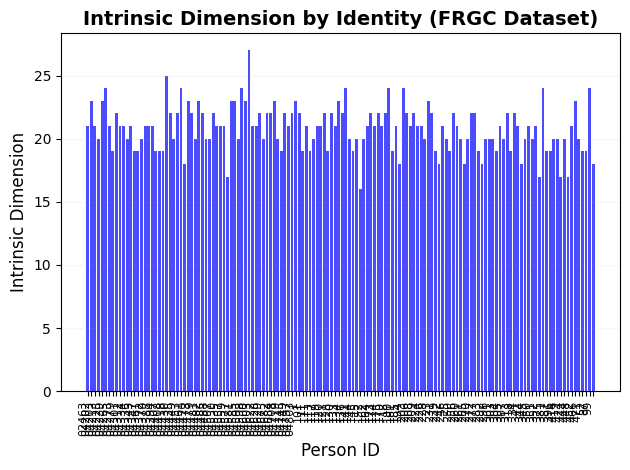

In [13]:
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())
labels_plot = identities #person IDs as labels

plt.bar(labels_plot, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity (FRGC Dataset)', fontsize=14, fontweight='bold')
plt.xlabel('Person ID', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

In [14]:
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())
n = len(identities)
bar_width = 0.8
width_per_bar = 0.10
fig_width = max(18, n * width_per_bar) 
fig_height = 8

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.bar(range(n), dimensions, color='blue', alpha=0.8, width=bar_width)
ax.set_xticks(range(n))
ax.set_xticklabels(identities, rotation=90, fontsize=6)
ax.set_xlabel('Person ID', fontsize=12)
ax.set_ylabel('Intrinsic Dimension', fontsize=12)
ax.set_title('Intrinsic Dimension by Identity (FRGC Dataset) — all labels', fontsize=14)
ax.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
fig.savefig('intrinsic_all_labels_filters.png', dpi=150, bbox_inches='tight')
plt.close(fig)

from IPython.display import HTML, display #html container with scroll so labels dont overlap
display(HTML(f"<div style='width:100%; overflow:auto; border:1px solid #ddd; padding:6px'><img src=\"{'intrinsic_all_labels.png'}\" style=\"height: auto;\"></div>"))

## 6. Visualization Clusters

Number of clusters: 142


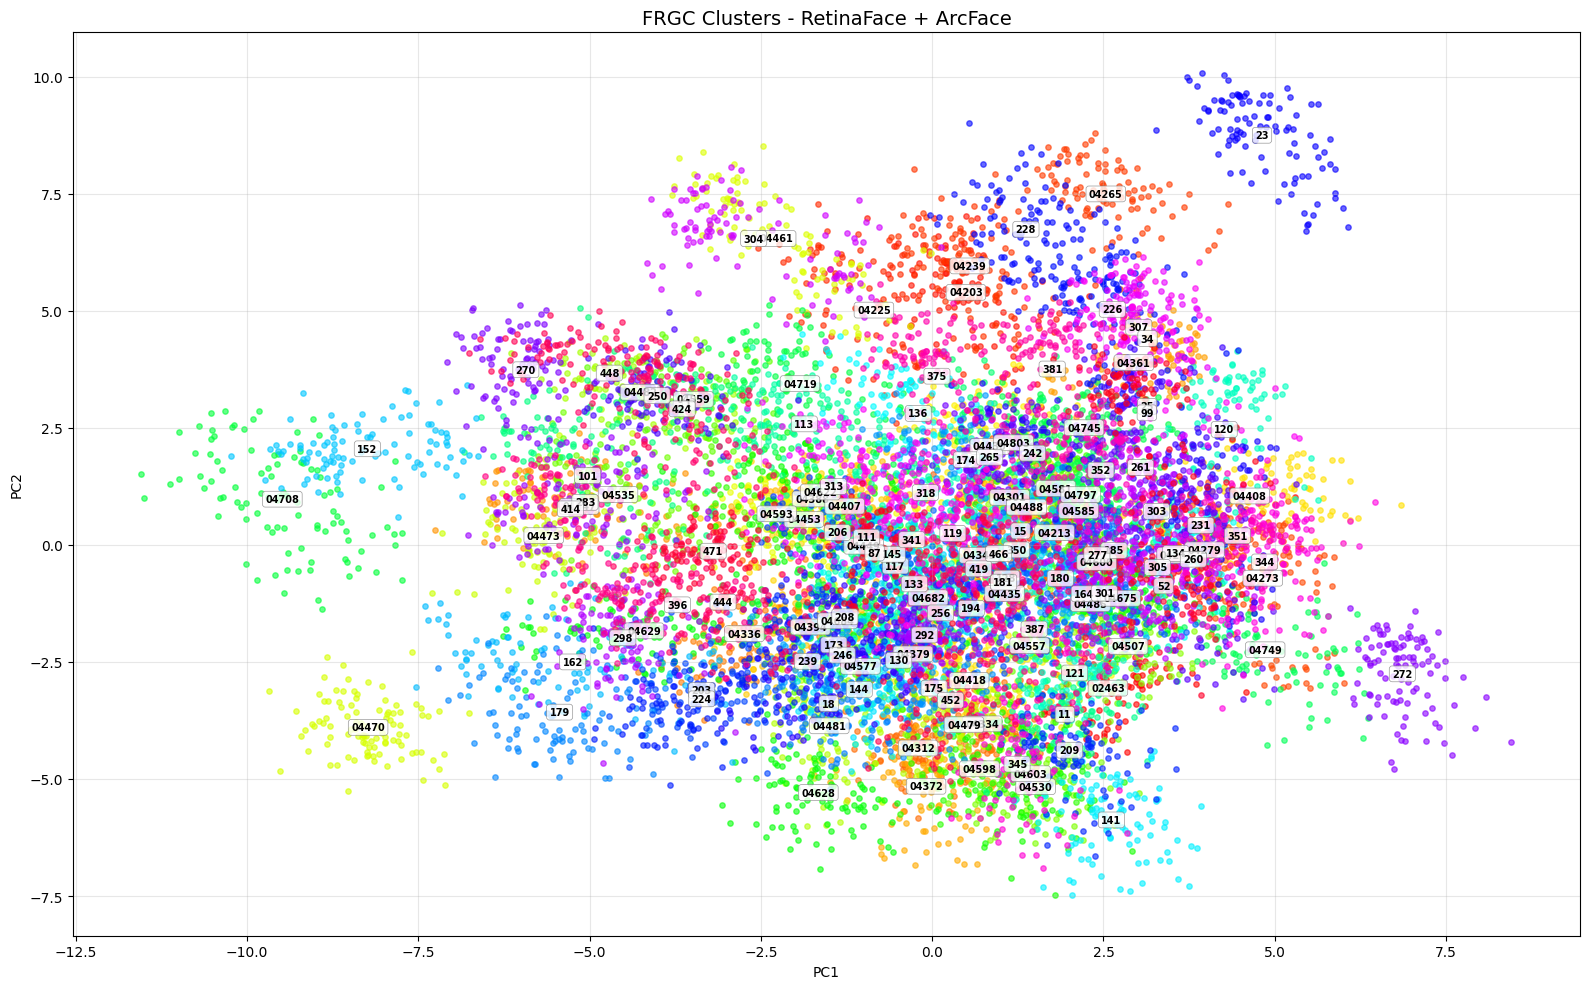

In [15]:
pca_2d = PCA(n_components=2)
emb_2d = pca_2d.fit_transform(embeddings)
centroids_2d = pca_2d.transform(np.array([cluster_stats[name]['centroid'] for name in cluster_stats.keys()]))

num_clusters = len(np.unique(valid_labels))
print(f"Number of clusters: {num_clusters}")
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    centroid_2d = cluster_points.mean(axis=0)  # centroid in 2d

    person_id = label_names[lbl]
    plt.text(centroid_2d[0], centroid_2d[1], person_id, fontsize=7, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5), fontweight='bold')

plt.title("FRGC Clusters - RetinaFace + ArcFace", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

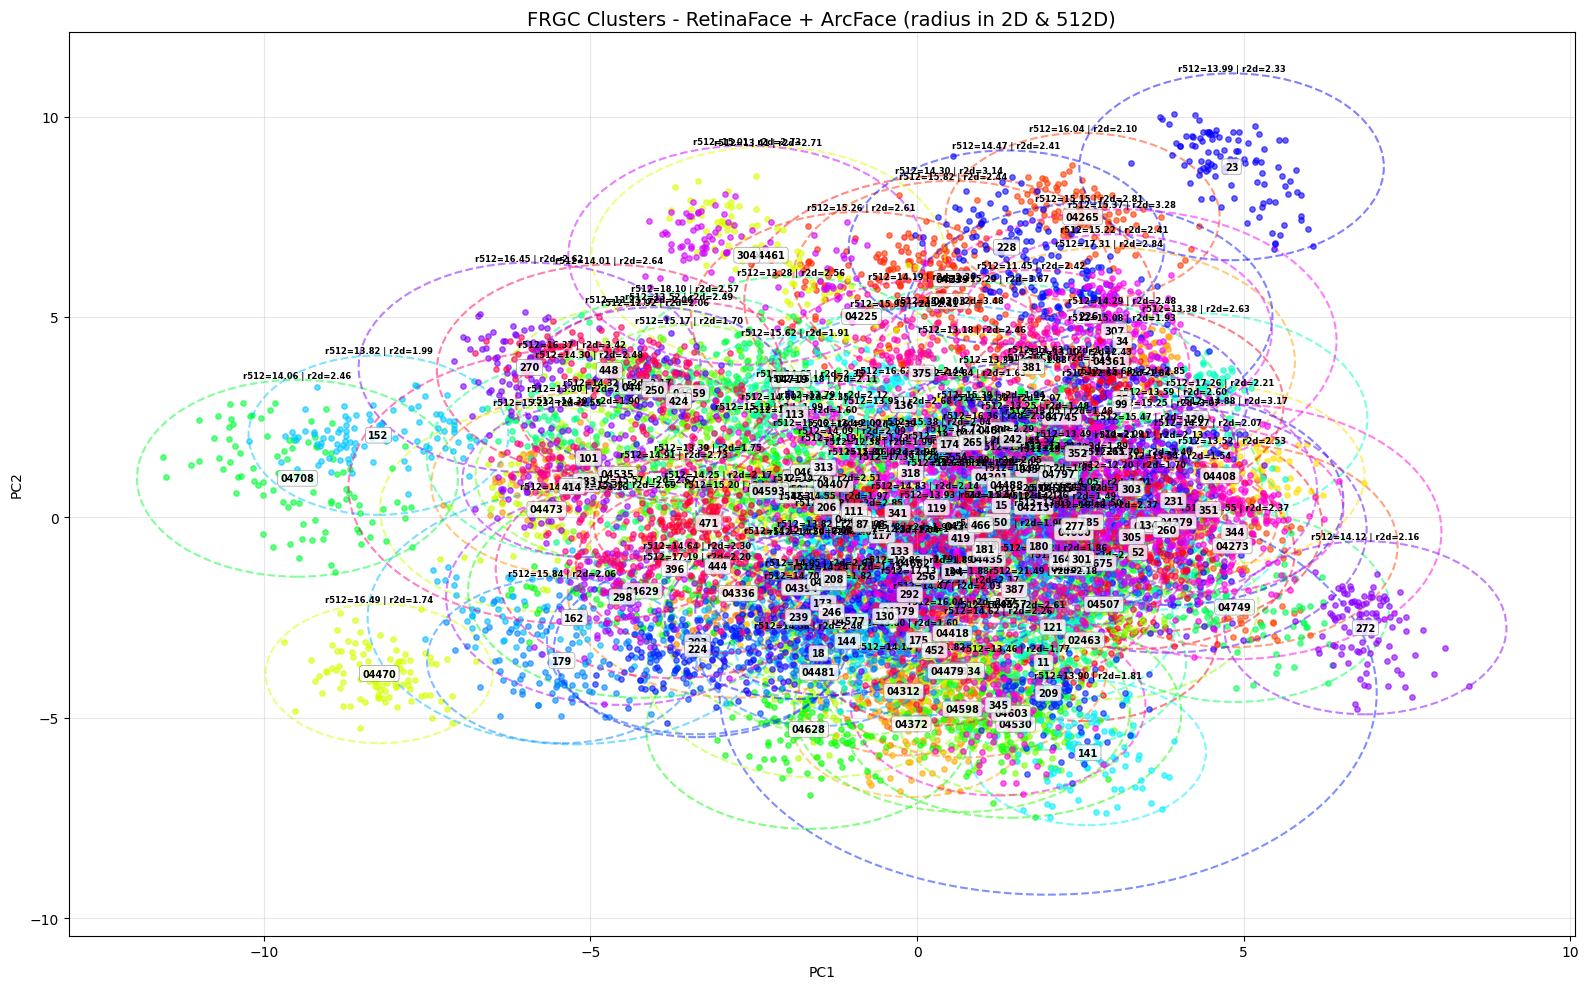

In [16]:
#same figure but with radius circles
plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    person_id = label_names[lbl]
    centroid_2d = cluster_points.mean(axis=0)  # centroid cluster in 2D space

    distances_2d = np.linalg.norm(cluster_points - centroid_2d, axis=1)  # max radius in 2D
    radius_2d = distances_2d.max()
    radius_512d = cluster_stats[person_id]['radius']  # radius in original 512D space

    circle = plt.Circle(centroid_2d, radius_2d, color=colors[idx], fill=False, linewidth=1.5, linestyle='--', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.text(centroid_2d[0], centroid_2d[1], person_id, fontsize=7, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')
    plt.text(centroid_2d[0], centroid_2d[1] + radius_2d, f'r512={radius_512d:.2f} | r2d={radius_2d:.2f}', fontsize=6, ha='center', va='bottom', color="black", fontweight='bold')

plt.title("FRGC Clusters - RetinaFace + ArcFace (radius in 2D & 512D)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
#top3 persons by number of imgs
sorted_by_images = sorted(cluster_stats.items(), key=lambda kv: kv[1]['num_images'], reverse=True)
top3 = sorted_by_images[:3]
person_ids = [pid for pid, _ in top3]
person_labels = []
for pid in person_ids:
    if 'label_names' in globals():
        matches = np.where(label_names == pid)[0]
        person_labels.append(int(matches[0]) if len(matches) > 0 else -1)
    else:
        person_labels.append(-1)
person1_label, person2_label, person3_label = person_labels[0], person_labels[1], person_labels[2]

In [18]:
person1_index = np.where(valid_labels == person1_label)[0] #index person
person2_index = np.where(valid_labels == person2_label)[0]
person3_index = np.where(valid_labels == person3_label)[0]

print(f"Person {person_ids[0]} (Label {person1_label}): {len(person1_index) if person1_index is not None else 0} images in dataset")
print(f"Person {person_ids[1]} (Label {person2_label}): {len(person2_index) if person2_index is not None else 0} images in dataset")
print(f"Person {person_ids[2]} (Label {person3_label}): {len(person3_index) if person3_index is not None else 0} images in dataset")

Person 02463 (Label 0): 100 images in dataset
Person 04202 (Label 2): 100 images in dataset
Person 04203 (Label 3): 100 images in dataset


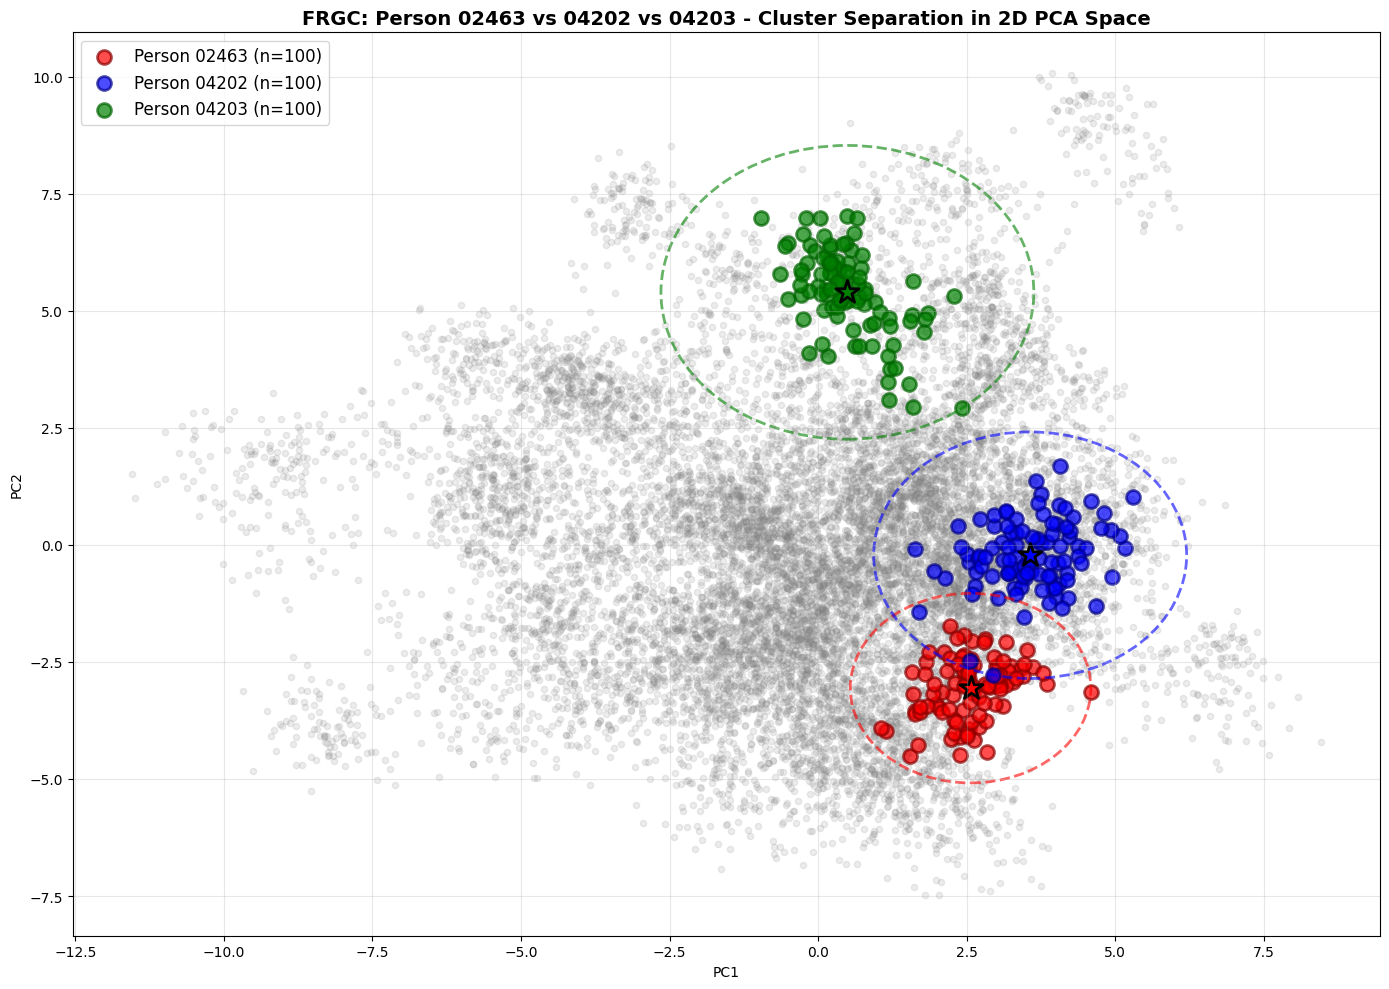

In [19]:
# 2d projections
person1_2d = emb_2d[valid_labels == person1_label]
person2_2d = emb_2d[valid_labels == person2_label]
person3_2d = emb_2d[valid_labels == person3_label]

#clusters
plt.figure(figsize=(14, 10))
# all other clusters in gray
for lbl in np.unique(valid_labels):
    if lbl not in [person1_label, person2_label, person3_label]:
        cluster_points = emb_2d[valid_labels == lbl]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20, alpha=0.15, color='gray', label=None)
#three persons
plt.scatter(person1_2d[:, 0], person1_2d[:, 1], s=100, alpha=0.7, color='red', edgecolors='darkred', linewidth=2, 
            label=f'Person {person_ids[0]} (n={len(person1_2d)})')
plt.scatter(person2_2d[:, 0], person2_2d[:, 1], s=100, alpha=0.7, color='blue', edgecolors='darkblue', linewidth=2, 
            label=f'Person {person_ids[1]} (n={len(person2_2d)})')
plt.scatter(person3_2d[:, 0], person3_2d[:, 1], s=100, alpha=0.7, color='green', edgecolors='darkgreen', linewidth=2, 
            label=f'Person {person_ids[2]} (n={len(person3_2d)})')

#centroids
person1_centroid = person1_2d.mean(axis=0)
person2_centroid = person2_2d.mean(axis=0)
person3_centroid = person3_2d.mean(axis=0)
plt.scatter(*person1_centroid, s=300, marker='*', color='red', edgecolors='black', linewidth=2)
plt.scatter(*person2_centroid, s=300, marker='*', color='blue', edgecolors='black', linewidth=2)
plt.scatter(*person3_centroid, s=300, marker='*', color='green', edgecolors='black', linewidth=2)

#circles
person1_radius_2d = np.linalg.norm(person1_2d - person1_centroid, axis=1).max()
person2_radius_2d = np.linalg.norm(person2_2d - person2_centroid, axis=1).max()
person3_radius_2d = np.linalg.norm(person3_2d - person3_centroid, axis=1).max()
circle_1 = plt.Circle(person1_centroid, person1_radius_2d, color='red', fill=False, linewidth=2, linestyle='--', alpha=0.6)
circle_2 = plt.Circle(person2_centroid, person2_radius_2d, color='blue', fill=False, linewidth=2, linestyle='--', alpha=0.6)
circle_3 = plt.Circle(person3_centroid, person3_radius_2d, color='green', fill=False, linewidth=2, linestyle='--', alpha=0.6)
plt.gca().add_patch(circle_1)
plt.gca().add_patch(circle_2)
plt.gca().add_patch(circle_3)

plt.title(f'FRGC: Person {person_ids[0]} vs {person_ids[1]} vs {person_ids[2]} - Cluster Separation in 2D PCA Space', fontsize=14, fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
print("="*70)
print(f"PERSON {person_ids[0]} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(person1_2d)}")
print(f"Cluster radius (512D): {cluster_stats[person_ids[0]]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[person_ids[0]]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[person_ids[0]]}")
print(f"Cluster radius (2D PCA): {person1_radius_2d}")
print()

print("="*70)
print(f"PERSON {person_ids[1]} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(person2_2d)}")
print(f"Cluster radius (512D): {cluster_stats[person_ids[1]]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[person_ids[1]]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[person_ids[1]]}")
print(f"Cluster radius (2D PCA): {person2_radius_2d}")
print()

print("="*70)
print(f"PERSON {person_ids[2]} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(person3_2d)}")
print(f"Cluster radius (512D): {cluster_stats[person_ids[2]]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[person_ids[2]]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[person_ids[2]]}")
print(f"Cluster radius (2D PCA): {person3_radius_2d}")
print()

print("="*70)
print("COSINE SIMILARITY BETWEEN CENTROIDS:")
print("="*70)
person1_centroid_512d = cluster_stats[person_ids[0]]['centroid']
person2_centroid_512d = cluster_stats[person_ids[1]]['centroid']
person3_centroid_512d = cluster_stats[person_ids[2]]['centroid']
sim_1_2 = cosine_similarity(person1_centroid_512d.reshape(1, -1), person2_centroid_512d.reshape(1, -1))[0, 0]
sim_1_3 = cosine_similarity(person1_centroid_512d.reshape(1, -1), person3_centroid_512d.reshape(1, -1))[0, 0]
sim_2_3 = cosine_similarity(person2_centroid_512d.reshape(1, -1), person3_centroid_512d.reshape(1, -1))[0, 0]
print(f"Person {person_ids[0]} vs Person {person_ids[1]}: {sim_1_2}")
print(f"Person {person_ids[0]} vs Person {person_ids[2]}: {sim_1_3}")
print(f"Person {person_ids[1]} vs Person {person_ids[2]}: {sim_2_3}")
print()

print("="*70)
print("Euclidean distances between centroids:")
print("="*70)
print(f"Person {person_ids[0]} to Person {person_ids[1]}: {np.linalg.norm(person1_centroid_512d - person2_centroid_512d)}")
print(f"Person {person_ids[0]} to Person {person_ids[2]}: {np.linalg.norm(person1_centroid_512d - person3_centroid_512d)}")
print(f"Person {person_ids[1]} to Person {person_ids[2]}: {np.linalg.norm(person2_centroid_512d - person3_centroid_512d)}")

PERSON 02463 CLUSTER STATISTICS:
Number of images: 100
Cluster radius (512D): 14.446113715968359
Cluster dispersion (512D): 1.3690947080989437
Intrinsic dimension: 21
Cluster radius (2D PCA): 2.0238248812645137

PERSON 04202 CLUSTER STATISTICS:
Number of images: 100
Cluster radius (512D): 15.471446946540732
Cluster dispersion (512D): 1.6131117763913063
Intrinsic dimension: 23
Cluster radius (2D PCA): 2.6328299311347347

PERSON 04203 CLUSTER STATISTICS:
Number of images: 100
Cluster radius (512D): 14.300714555917905
Cluster dispersion (512D): 2.0867684215571916
Intrinsic dimension: 21
Cluster radius (2D PCA): 3.137030613095053

COSINE SIMILARITY BETWEEN CENTROIDS:
Person 02463 vs Person 04202: 0.09778792031617005
Person 02463 vs Person 04203: -0.06950239104802372
Person 04202 vs Person 04203: -0.04974712684489384

Euclidean distances between centroids:
Person 02463 to Person 04202: 26.251345319024743
Person 02463 to Person 04203: 26.280348574657022
Person 04202 to Person 04203: 27.83647

In [21]:
individuals = [person_ids[0], person_ids[1], person_ids[2]]
short_names = individuals #id for the person
colors_bar = ['red', 'blue', 'green']

metrics = {
    'num_images': [len(person1_2d), len(person2_2d), len(person3_2d)],
    'radius_512d': [cluster_stats[name]['radius'] for name in individuals],
    'dispersion_512d': [cluster_stats[name]['dispersion'] for name in individuals],
    'intrinsic_dims': [intrinsic_dim[name] for name in individuals],
    'radius_2d': [person1_radius_2d, person2_radius_2d, person3_radius_2d]
}

cos_sim_matrix = np.array([[1.0, sim_1_2, sim_1_3],
                           [sim_1_2, 1.0, sim_2_3],
                           [sim_1_3, sim_2_3, 1.0]])

eucl_dist_matrix = np.array([[0, np.linalg.norm(person1_centroid_512d - person2_centroid_512d), np.linalg.norm(person1_centroid_512d - person3_centroid_512d)],
                             [np.linalg.norm(person1_centroid_512d - person2_centroid_512d), 0, np.linalg.norm(person2_centroid_512d - person3_centroid_512d)],
                             [np.linalg.norm(person1_centroid_512d - person3_centroid_512d), np.linalg.norm(person2_centroid_512d - person3_centroid_512d), 0]])

/tmp/ipykernel_167278/3102313069.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


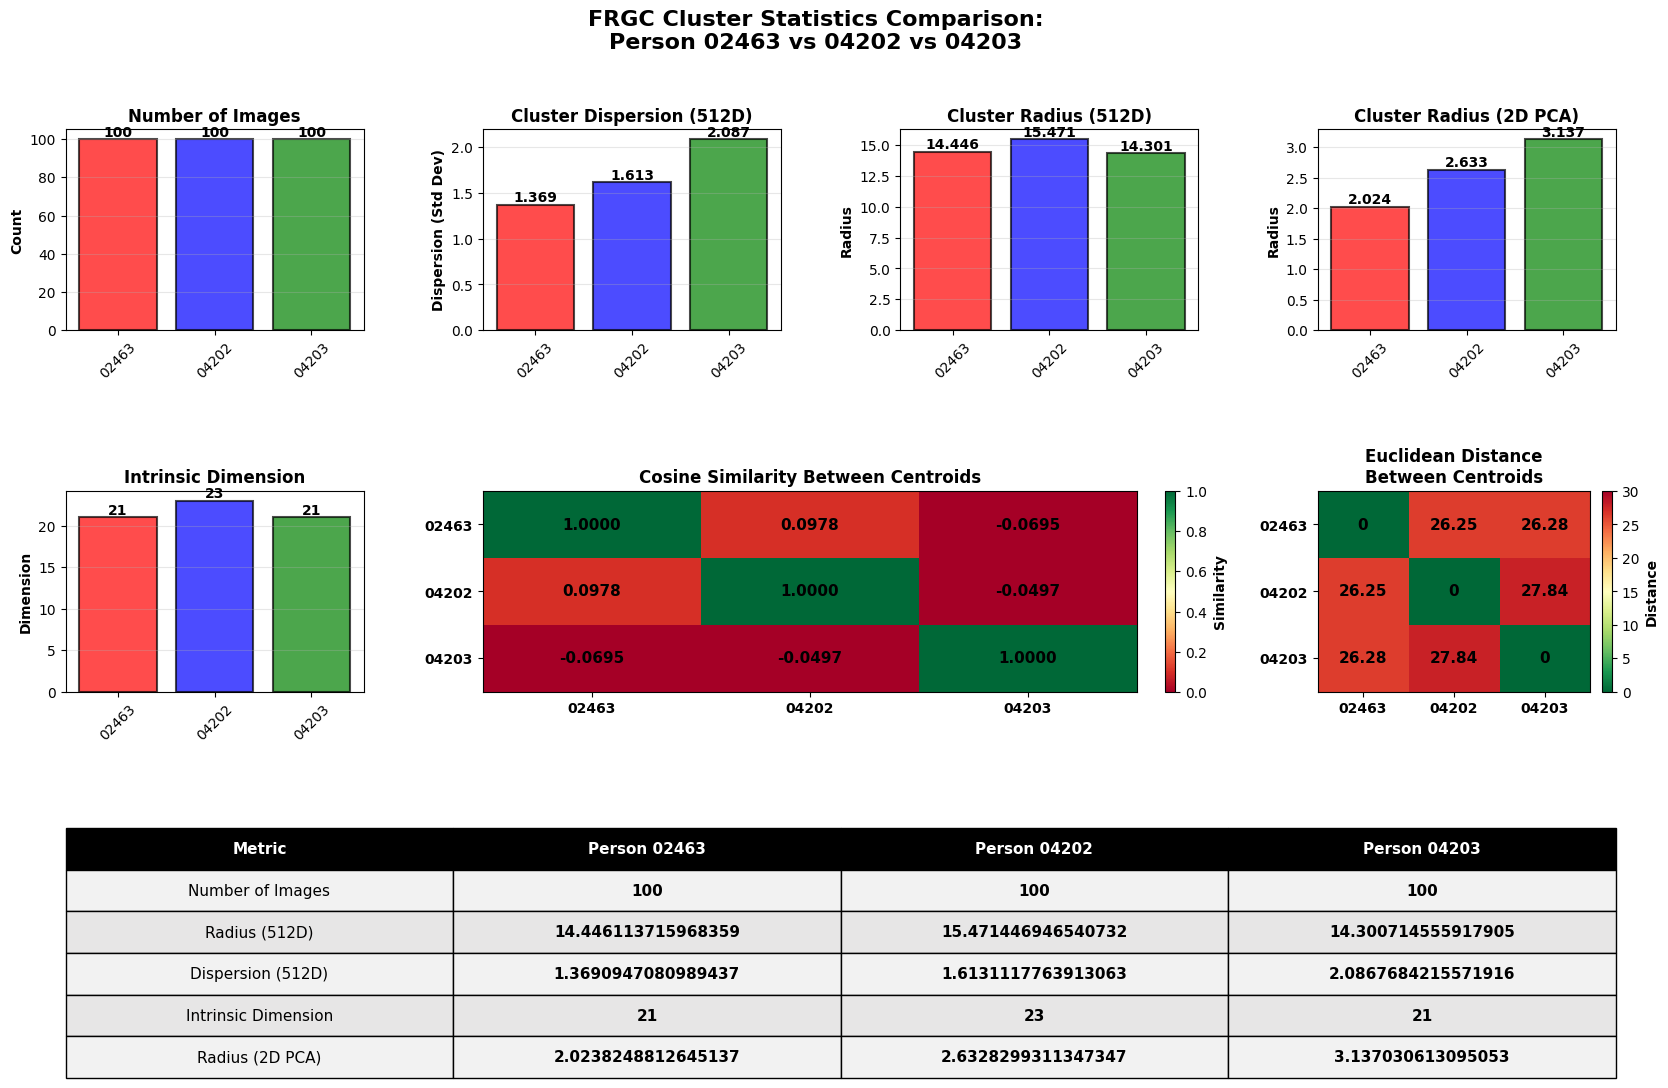

In [22]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.8, wspace=0.4)

#number of images
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(individuals, metrics['num_images'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Number of Images', fontweight='bold', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, metrics['num_images']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{val}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

#cluster dispersion 512D
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(individuals, metrics['dispersion_512d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Dispersion (Std Dev)', fontweight='bold')
ax2.set_title('Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, metrics['dispersion_512d']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

#cluster radius 512D
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(individuals, metrics['radius_512d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Radius', fontweight='bold')
ax3.set_title('Cluster Radius (512D)', fontweight='bold', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
for bar, val in zip(bars3, metrics['radius_512d']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

#cluster radius 2D PCA
ax4 = fig.add_subplot(gs[0, 3])
bars4 = ax4.bar(individuals, metrics['radius_2d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Radius', fontweight='bold')
ax4.set_title('Cluster Radius (2D PCA)', fontweight='bold', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
for bar, val in zip(bars4, metrics['radius_2d']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

#intrinsic dimension
ax5 = fig.add_subplot(gs[1, 0])
bars5 = ax5.bar(individuals, metrics['intrinsic_dims'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Dimension', fontweight='bold')
ax5.set_title('Intrinsic Dimension', fontweight='bold', fontsize=12)
ax5.tick_params(axis='x', rotation=45)
for bar, val in zip(bars5, metrics['intrinsic_dims']):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height, f'{val}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

#cosine similarity
ax6 = fig.add_subplot(gs[1, 1:3])
im1 = ax6.imshow(cos_sim_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
ax6.set_xticks(range(3))
ax6.set_yticks(range(3))
ax6.set_xticklabels(short_names, fontweight='bold')
ax6.set_yticklabels(short_names, fontweight='bold')
ax6.set_title('Cosine Similarity Between Centroids', fontweight='bold', fontsize=12)
for i in range(3):
    for j in range(3):
        text = ax6.text(j, i, f'{cos_sim_matrix[i, j]:.4f}',ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax6, fraction=0.046, pad=0.04)
cbar1.set_label('Similarity', fontweight='bold')

#euclidean distance heatmap
ax7 = fig.add_subplot(gs[1, 3])
im2 = ax7.imshow(eucl_dist_matrix, cmap='RdYlGn_r', vmin=0, vmax=30, aspect='auto')
ax7.set_xticks(range(3))
ax7.set_yticks(range(3))
ax7.set_xticklabels(short_names, fontweight='bold')
ax7.set_yticklabels(short_names, fontweight='bold')
ax7.set_title('Euclidean Distance\nBetween Centroids', fontweight='bold', fontsize=12)
for i in range(3):
    for j in range(3):
        val = eucl_dist_matrix[i, j]
        text = ax7.text(j, i, f'{val:.2f}' if val > 0 else '0',ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax7, fraction=0.046, pad=0.04)
cbar2.set_label('Distance', fontweight='bold')

#comparative metrics table
ax8 = fig.add_subplot(gs[2, :])
ax8.axis('tight')
ax8.axis('off')
table_data = [
    ['Metric', f'Person {individuals[0]}', f'Person {individuals[1]}', f'Person {individuals[2]}'],
    ['Number of Images', metrics['num_images'][0], metrics['num_images'][1], metrics['num_images'][2]],
    ['Radius (512D)', metrics['radius_512d'][0], metrics['radius_512d'][1], metrics['radius_512d'][2]],
    ['Dispersion (512D)', metrics['dispersion_512d'][0], metrics['dispersion_512d'][1], metrics['dispersion_512d'][2]],
    ['Intrinsic Dimension', metrics['intrinsic_dims'][0], metrics['intrinsic_dims'][1], metrics['intrinsic_dims'][2]],
    ['Radius (2D PCA)', metrics['radius_2d'][0], metrics['radius_2d'][1], metrics['radius_2d'][2]],
]
table = ax8.table(cellText=table_data, cellLoc='center', loc='center',colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

#header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('black')
    cell.set_text_props(weight='bold', color='white')
#data rows with alternating colors
for i in range(1, 6):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E7E6E6')
        else:
            cell.set_facecolor('#F2F2F2')
        if j > 0:  # Data columns
            cell.set_text_props(weight='bold')

plt.suptitle(f'FRGC Cluster Statistics Comparison:\nPerson {individuals[0]} vs {individuals[1]} vs {individuals[2]}',fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 7. Cosine similarity between clusters

In [23]:
similarities = []
identity_pairs = []

for lbl1, lbl2 in zip(np.unique(valid_labels)[:-1], np.unique(valid_labels)[1:]):
    c1 = cluster_stats[label_names[lbl1]]['centroid']
    c2 = cluster_stats[label_names[lbl2]]['centroid']
    sim = cosine_similarity(c1.reshape(1,-1), c2.reshape(1,-1))[0,0]
    similarities.append(sim)
    identity_pairs.append(f"{label_names[lbl1][:3]} vs {label_names[lbl2][:3]}")
    print(f"Cosine similarity {label_names[lbl1]} vs {label_names[lbl2]}: {sim}")

Cosine similarity 02463 vs 04202: 0.09778792031617005
Cosine similarity 04202 vs 04203: -0.04974712684489384
Cosine similarity 04203 vs 04213: 0.05668956529239155
Cosine similarity 04213 vs 04225: -0.02745599019512159
Cosine similarity 04225 vs 04239: 0.08861946415156823
Cosine similarity 04239 vs 04265: 0.09894334701800941
Cosine similarity 04265 vs 04273: 0.08879411092191075
Cosine similarity 04273 vs 04279: 0.03910066756238344
Cosine similarity 04279 vs 04301: 0.008816685825853057
Cosine similarity 04301 vs 04312: -0.03026461736981395
Cosine similarity 04312 vs 04334: -0.09058248991543882
Cosine similarity 04334 vs 04336: -0.10849340930028285
Cosine similarity 04336 vs 04343: 0.04980825677022758
Cosine similarity 04343 vs 04347: -0.05826066193229577
Cosine similarity 04347 vs 04361: 0.030879423168819833
Cosine similarity 04361 vs 04372: -0.09887254549850703
Cosine similarity 04372 vs 04379: 0.01810706995703419
Cosine similarity 04379 vs 04388: 0.12082775597172755
Cosine similarity 0

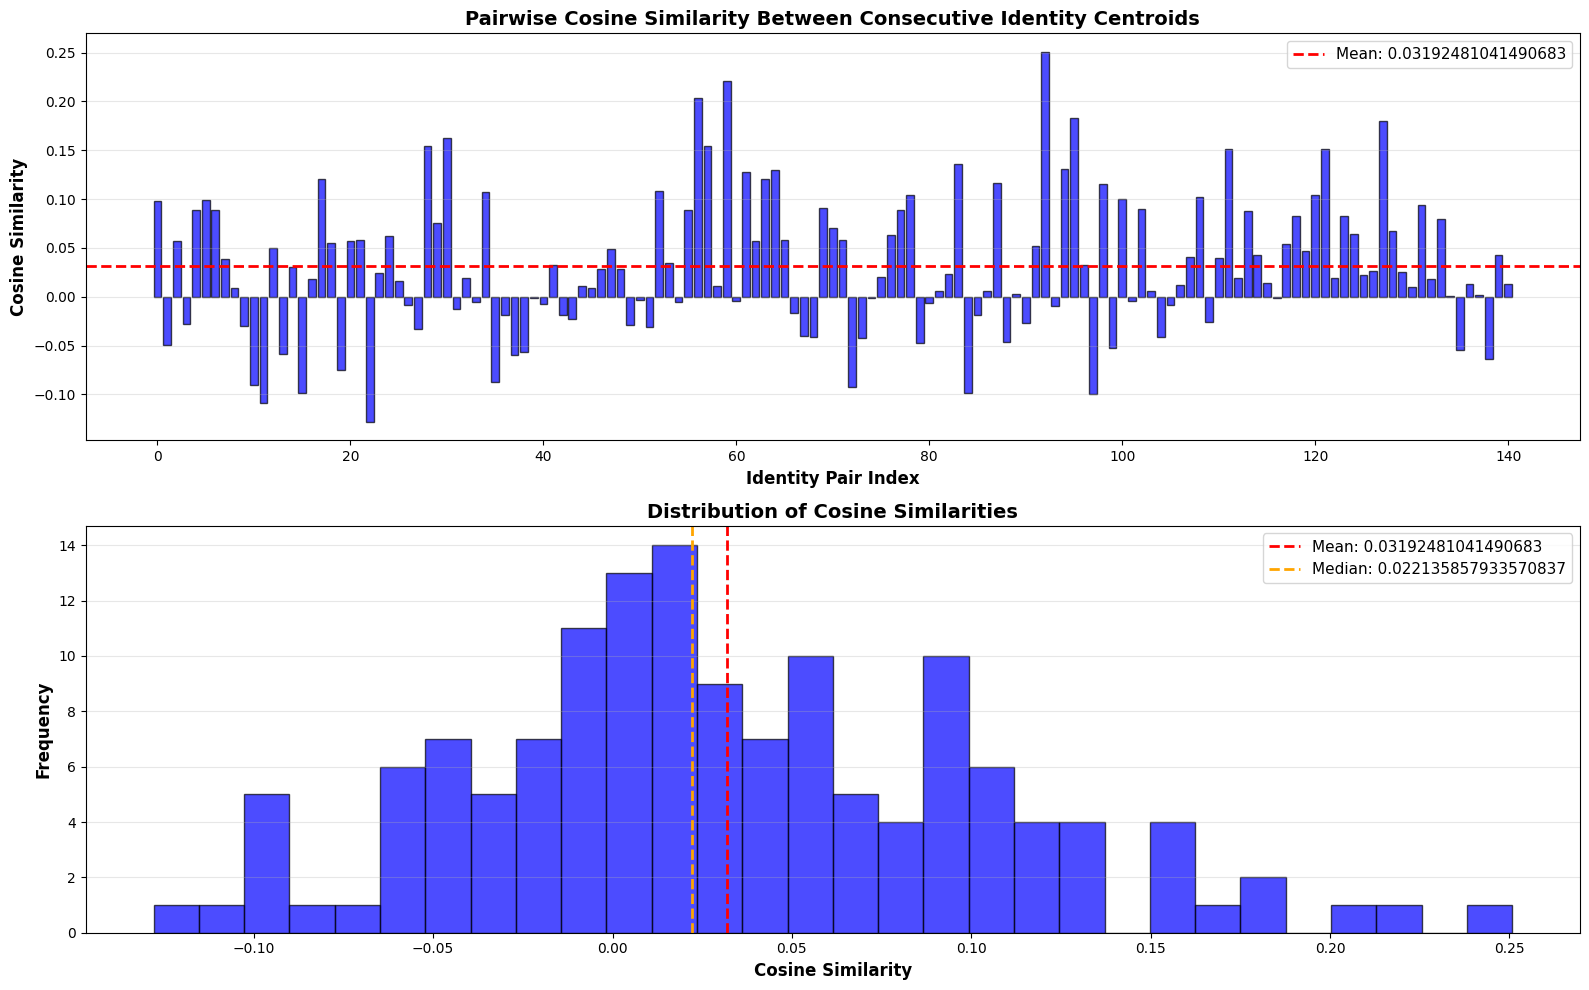

COSINE SIMILARITY STATISTICS (Consecutive Pairs):
Mean similarity: 0.03192481041490683
Median similarity: 0.022135857933570837
Std deviation: 0.07055971426488741
Min similarity: -0.12791879458493105
Max similarity: 0.2507280436771502


In [24]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

#cosine similarities
axes[0].bar(range(len(similarities)), similarities, color='blue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[0].set_xlabel('Identity Pair Index', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[0].set_title('Pairwise Cosine Similarity Between Consecutive Identity Centroids', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
#distribution histogram
axes[1].hist(similarities, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[1].axvline(x=np.median(similarities), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities)}')
axes[1].set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#stats
print("="*70)
print("COSINE SIMILARITY STATISTICS (Consecutive Pairs):")
print("="*70)
print(f"Mean similarity: {np.mean(similarities)}")
print(f"Median similarity: {np.median(similarities)}")
print(f"Std deviation: {np.std(similarities)}")
print(f"Min similarity: {np.min(similarities)}")
print(f"Max similarity: {np.max(similarities)}")

## 8. Analyze cluster stats

In [25]:
#cluster data to DataFrame
cluster_stats_df = pd.DataFrame.from_dict(cluster_stats, orient='index')
print(cluster_stats_df.head())

                                                centroid     radius  \
02463  [1.3797886028999997, -0.595679604044, 0.809980...  14.446114   
04202  [0.4879912725600001, -0.5704711765669999, 0.64...  15.471447   
04203  [-1.2157651860000003, 0.45754731698099976, 0.4...  14.300715   
04213  [1.2461123257, 0.3417087388200001, -2.44010198...  13.431779   
04225  [0.21785990349999998, 0.33852936605999995, -0....  15.263124   

       dispersion  num_images  
02463    1.369095         100  
04202    1.613112         100  
04203    2.086768         100  
04213    1.616827         100  
04225    1.466839         100  


In [26]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
merged_df = intrinsic_dim_df.merge(cluster_stats_df, left_index=True, right_index=True)
print("Merged DataFrame created successfully")
print(merged_df.head())

Merged DataFrame created successfully
       intrinsic_dimension                                           centroid  \
02463                   21  [1.3797886028999997, -0.595679604044, 0.809980...   
04202                   23  [0.4879912725600001, -0.5704711765669999, 0.64...   
04203                   21  [-1.2157651860000003, 0.45754731698099976, 0.4...   
04213                   20  [1.2461123257, 0.3417087388200001, -2.44010198...   
04225                   23  [0.21785990349999998, 0.33852936605999995, -0....   

          radius  dispersion  num_images  
02463  14.446114    1.369095         100  
04202  15.471447    1.613112         100  
04203  14.300715    2.086768         100  
04213  13.431779    1.616827         100  
04225  15.263124    1.466839         100  


In [27]:
print("Summary Statistics for Merged DataFrame:")
print(merged_df[['intrinsic_dimension', 'radius', 'dispersion', 'num_images']].describe())

Summary Statistics for Merged DataFrame:
       intrinsic_dimension      radius  dispersion  num_images
count           142.000000  142.000000  142.000000       142.0
mean             20.802817   14.888096    1.532279       100.0
std               1.799288    1.937676    0.270617         0.0
min              16.000000   11.450487    1.041174       100.0
25%              20.000000   13.819958    1.351895       100.0
50%              21.000000   14.556134    1.498960       100.0
75%              22.000000   15.452422    1.694650       100.0
max              27.000000   25.981397    2.337491       100.0


In [28]:
print("\nIdentities with most consistent face embeddings (smallest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=True).head())

print("\nIdentities with least consistent face embeddings (largest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=False).head())

print("\nIdentities with least dispersed embeddings (smallest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=True).head())

print("\nIdentities with most dispersed embeddings (largest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=False).head())

print("\nIndividuals with the most images:")
print(cluster_stats_df.sort_values(by='num_images', ascending=False).head())


Identities with most consistent face embeddings (smallest radius):
                                                centroid     radius  \
381    [-2.194184222, -0.3590427746480001, 0.73938940...  11.450487   
04745  [0.22213407019999992, 0.7785637643000001, -2.2...  11.633924   
301    [-0.24892660995000007, -0.31977102409800023, 1...  11.832932   
305    [-0.079018176319, -0.40628538674999976, -0.654...  12.195686   
292    [-0.009831773494200004, 0.41190823112200015, 0...  12.331644   

       dispersion  num_images  
381      1.119759         100  
04745    1.297804         100  
301      1.324477         100  
305      1.503690         100  
292      1.476456         100  

Identities with least consistent face embeddings (largest radius):
                                                centroid     radius  \
209    [-0.6346750983500002, 0.49830133050000003, 0.2...  25.981397   
04334  [1.5112868793999996, -0.7065900028800001, -0.4...  22.308813   
11     [-0.7479068983900001, -0.

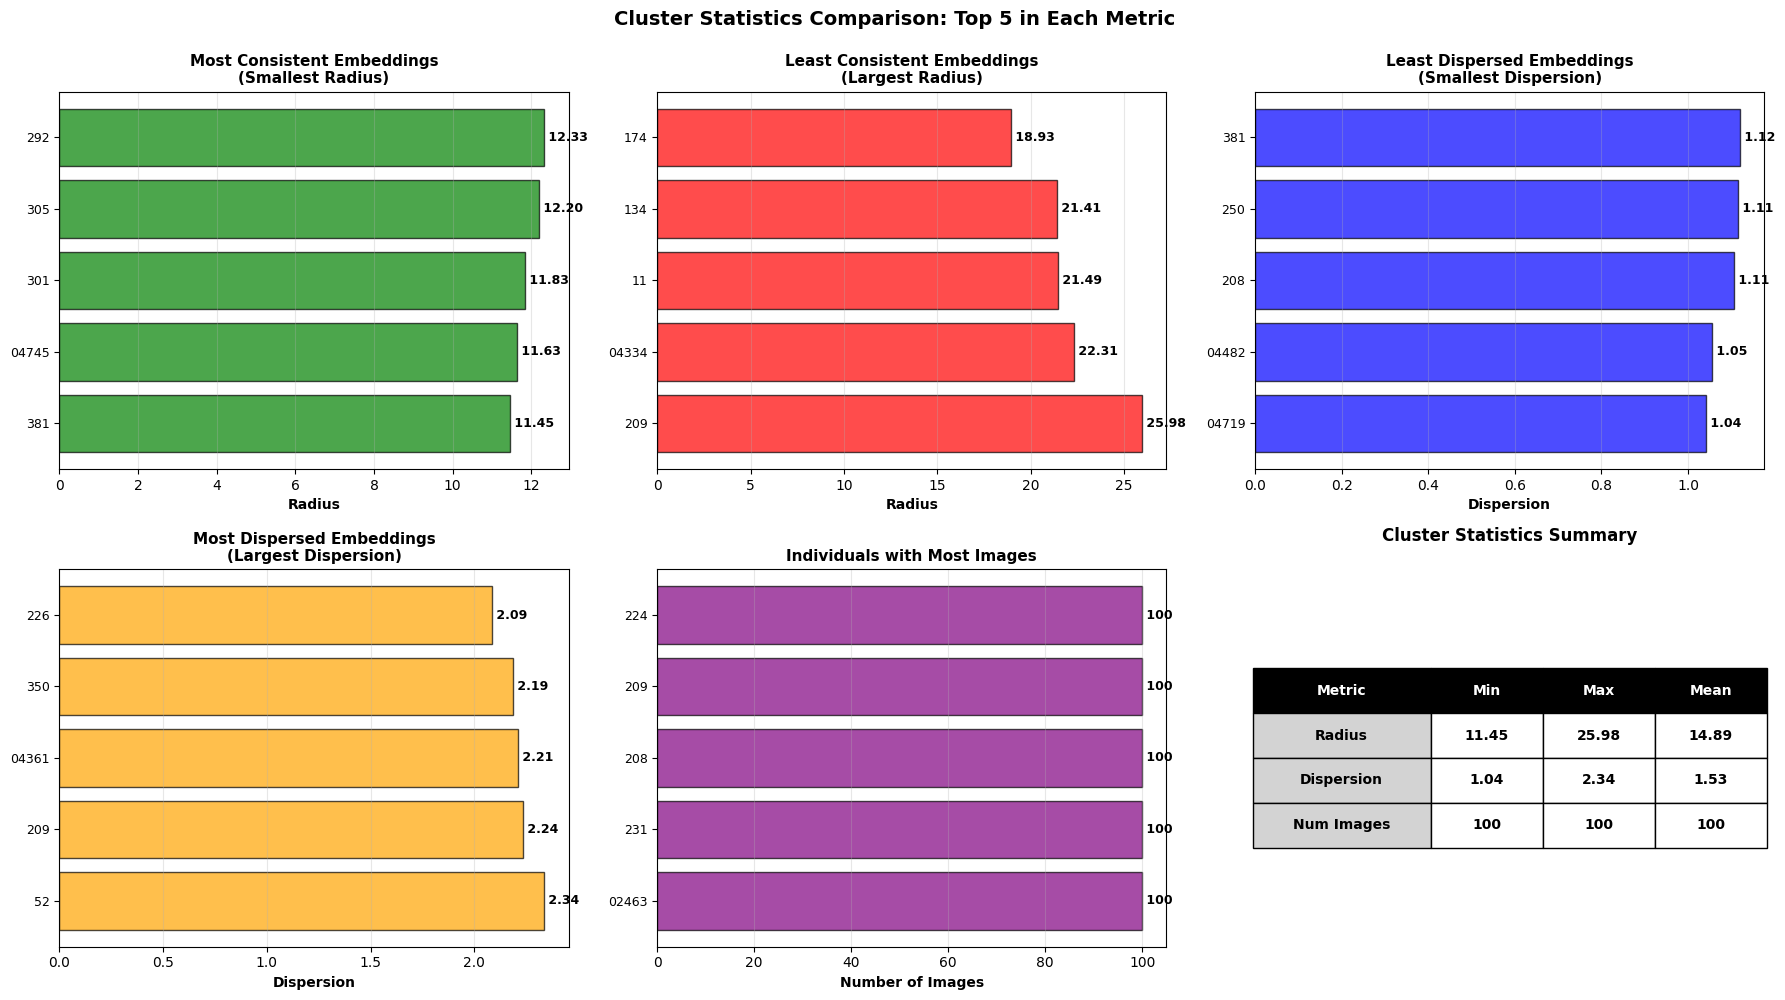

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#smallest radius (most consistent)
smallest_radius = cluster_stats_df.sort_values(by='radius', ascending=True).head()
axes[0, 0].barh(range(len(smallest_radius)), smallest_radius['radius'], color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(smallest_radius)))
axes[0, 0].set_yticklabels(smallest_radius.index, fontsize=9)
axes[0, 0].set_xlabel('Radius', fontweight='bold')
axes[0, 0].set_title('Most Consistent Embeddings\n(Smallest Radius)', fontweight='bold', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_radius['radius']):
    axes[0, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest radius (least consistent)
largest_radius = cluster_stats_df.sort_values(by='radius', ascending=False).head()
axes[0, 1].barh(range(len(largest_radius)), largest_radius['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(largest_radius)))
axes[0, 1].set_yticklabels(largest_radius.index, fontsize=9)
axes[0, 1].set_xlabel('Radius', fontweight='bold')
axes[0, 1].set_title('Least Consistent Embeddings\n(Largest Radius)', fontweight='bold', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_radius['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#smallest dispersion
smallest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=True).head()
axes[0, 2].barh(range(len(smallest_dispersion)), smallest_dispersion['dispersion'], color='blue', alpha=0.7, edgecolor='black')
axes[0, 2].set_yticks(range(len(smallest_dispersion)))
axes[0, 2].set_yticklabels(smallest_dispersion.index, fontsize=9)
axes[0, 2].set_xlabel('Dispersion', fontweight='bold')
axes[0, 2].set_title('Least Dispersed Embeddings\n(Smallest Dispersion)', fontweight='bold', fontsize=11)
axes[0, 2].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_dispersion['dispersion']):
    axes[0, 2].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest dispersion
largest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=False).head()
axes[1, 0].barh(range(len(largest_dispersion)), largest_dispersion['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(largest_dispersion)))
axes[1, 0].set_yticklabels(largest_dispersion.index, fontsize=9)
axes[1, 0].set_xlabel('Dispersion', fontweight='bold')
axes[1, 0].set_title('Most Dispersed Embeddings\n(Largest Dispersion)', fontweight='bold', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_dispersion['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#images
most_images = cluster_stats_df.sort_values(by='num_images', ascending=False).head()
axes[1, 1].barh(range(len(most_images)), most_images['num_images'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(most_images)))
axes[1, 1].set_yticklabels(most_images.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Individuals with Most Images', fontweight='bold', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(most_images['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#statistics table
axes[1, 2].axis('tight')
axes[1, 2].axis('off')
summary_data = [
    ['Metric', 'Min', 'Max', 'Mean'],
    ['Radius', f"{cluster_stats_df['radius'].min():.2f}", f"{cluster_stats_df['radius'].max():.2f}", f"{cluster_stats_df['radius'].mean():.2f}"],
    ['Dispersion', f"{cluster_stats_df['dispersion'].min():.2f}", f"{cluster_stats_df['dispersion'].max():.2f}", f"{cluster_stats_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(cluster_stats_df['num_images'].min())}", f"{int(cluster_stats_df['num_images'].max())}", f"{int(cluster_stats_df['num_images'].mean())}"]
]
table = axes[1, 2].table(cellText=summary_data, cellLoc='center', loc='center', colWidths=[0.35, 0.22, 0.22, 0.22])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
for i in range(4): #header
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4): #rows
    table[(i, 0)].set_facecolor('#D3D3D3')
    table[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table[(i, j)].set_facecolor('white' if i % 2 == 0 else 'white')
        table[(i, j)].set_text_props(weight='bold')
axes[1, 2].set_title('Cluster Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle('Cluster Statistics Comparison: Top 5 in Each Metric', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

- **Smallest Radius:** small average distance of ther embeddings from their centroids = face embeddings are tightly clustered, so they have higher consistency across different imgs of the same person
- **Largest Radius:** largest average distance from their centroids. Face embeddings are more spread out, so they have less consistency or greater variation in their imgs
- **Smallest Dispersion:** so small deviation of distances from their centroids, so the variation in embedding consistency are very low
- **Largest Dispersion:** largest deviation of distances, so they have more variability in the consistency of their embeddings. High dispersion = wider range of conditions in the imgs (pose, light, expression...)
- **Most Images:** lead to larger radii or dispersion due to greater diversity

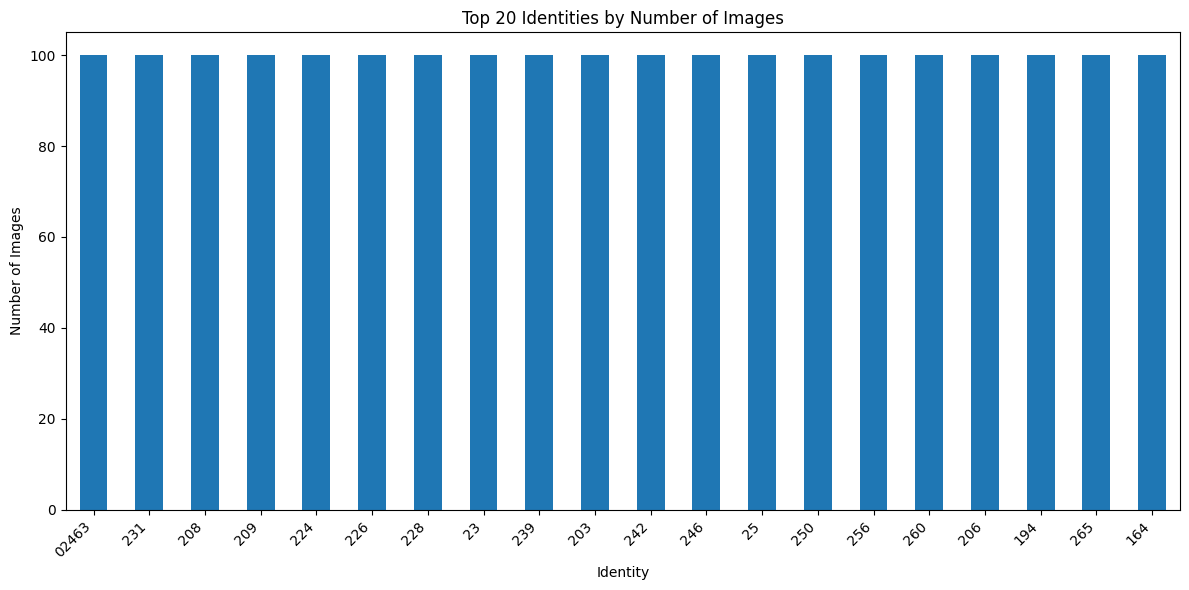

In [30]:
# number of imgs per identity bar plot
plt.figure(figsize=(12, 6))
top_n = 20  # Display top 20 identities
cluster_stats_df.sort_values(by='num_images', ascending=False).head(top_n)['num_images'].plot(kind='bar')
plt.title(f'Top {top_n} Identities by Number of Images')
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Scatter Plot: Intrinsic Dimension vs. Cluster Dispersion

Higher intrinsic complexity in a person's image set often correlates with greater variability in the consistency of their face embeddings. The ArcFace model, while robust, shows signs of this increased challenge through higher dispersion values for identities with higher intrinsic dimensions.

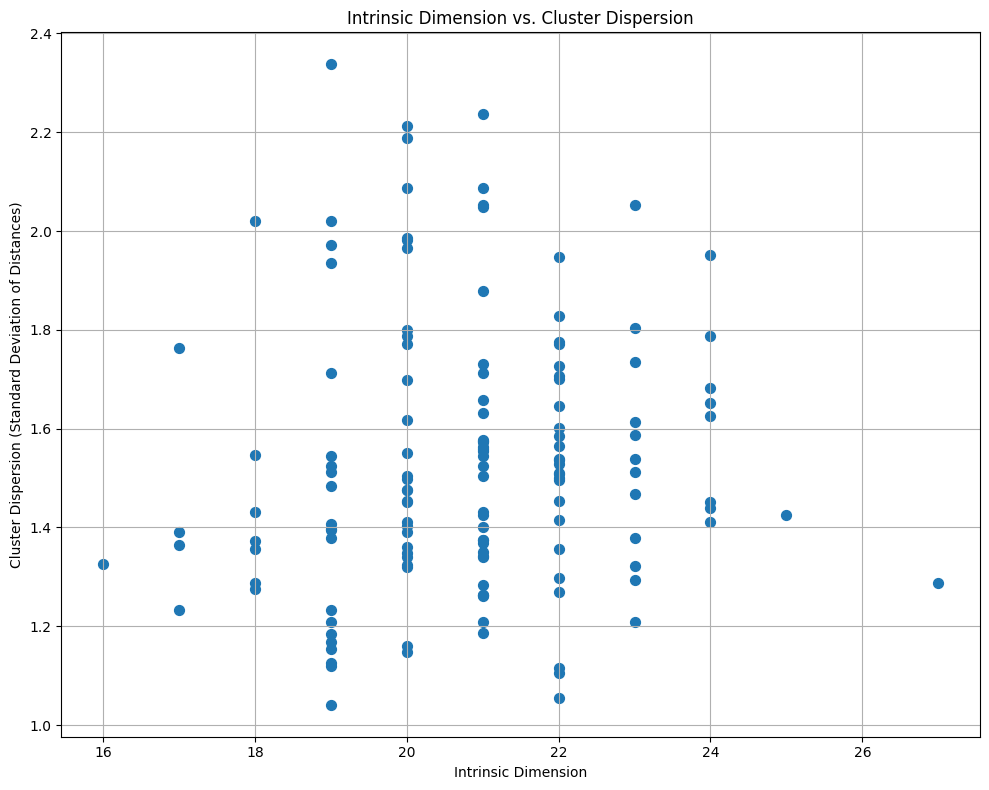

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['intrinsic_dimension'], merged_df['dispersion'], s=50)
plt.title('Intrinsic Dimension vs. Cluster Dispersion')
plt.xlabel('Intrinsic Dimension')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Scatter Plot: Radius vs Dispersion


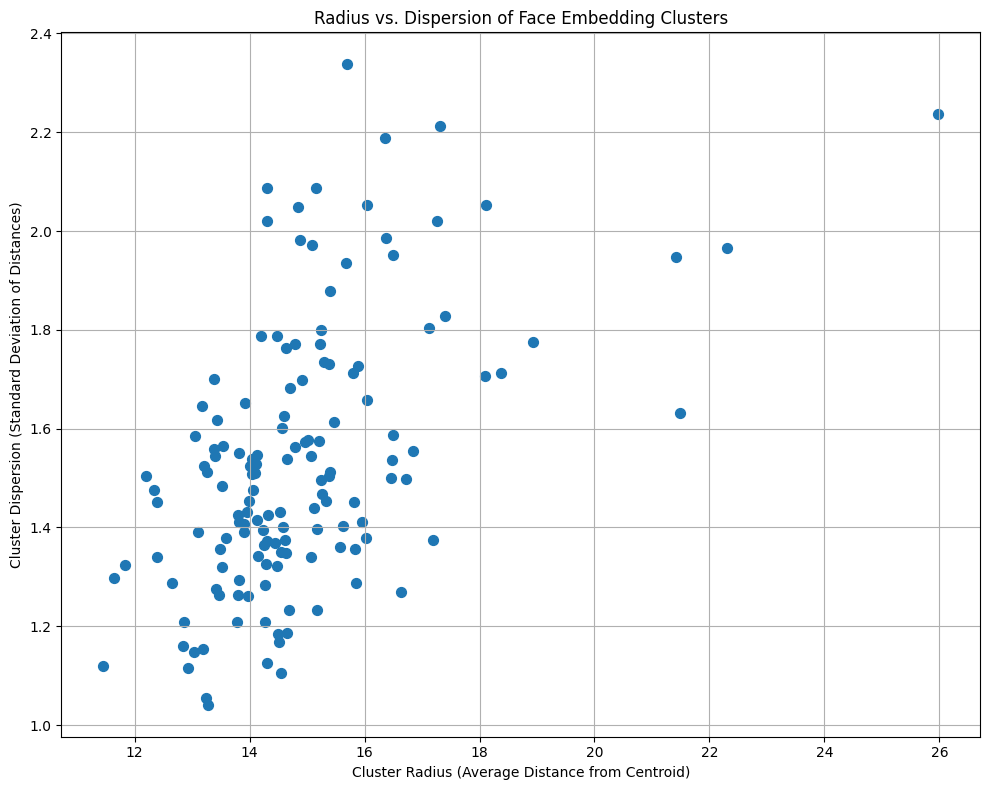

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(cluster_stats_df['radius'], cluster_stats_df['dispersion'], s=50)
plt.title('Radius vs. Dispersion of Face Embedding Clusters')
plt.xlabel('Cluster Radius (Average Distance from Centroid)')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Intrinsic Dimension of Clusters


In [33]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
print("Intrinsic Dimensionality DataFrame Head:")
print(intrinsic_dim_df.head())

Intrinsic Dimensionality DataFrame Head:
       intrinsic_dimension
02463                   21
04202                   23
04203                   21
04213                   20
04225                   23


In [34]:
print("\nDescriptive Statistics for Intrinsic Dimensionality:")
print(intrinsic_dim_df['intrinsic_dimension'].describe())

print("\nIdentities with the 10 highest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=False).head(10))

print("\nIdentities with the 10 lowest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=True).head(10))


Descriptive Statistics for Intrinsic Dimensionality:
count    142.000000
mean      20.802817
std        1.799288
min       16.000000
25%       20.000000
50%       21.000000
75%       22.000000
max       27.000000
Name: intrinsic_dimension, dtype: float64

Identities with the 10 highest intrinsic dimensions:
       intrinsic_dimension
04600                   27
04418                   25
375                     24
04593                   24
04453                   24
136                     24
194                     24
18                      24
04239                   24
87                      24

Identities with the 10 lowest intrinsic dimensions:
       intrinsic_dimension
15                      16
352                     17
04559                   17
444                     17
419                     17
99                      18
283                     18
261                     18
239                     18
341                     18



### Identities with High Intrinsic Dimensionality
exhibit a greater complexity or variability. This means that more principal components are needed to explain the variance within their respective clusters. This could be due to a wider range of poses, expressions, lighting conditions, or even image quality variations for these individuals in the LFW dataset.

### Identities with Low Intrinsic Dimensionality
their image clusters are less complex or more consistent. Fewer principal components are sufficient to capture the variance within their embeddings. This might imply that the images for these individuals are more uniform in terms of visual characteristics, or perhaps their facial features are inherently less variable across different images presented to the model.

In [35]:
top_10_high_intrinsic_dim_identities = intrinsic_dim_df.nlargest(10, 'intrinsic_dimension')
top_10_data = merged_df.loc[top_10_high_intrinsic_dim_identities.index][['intrinsic_dimension', 'radius', 'dispersion', 'num_images']]
print("\nMetrics for Identities with the 10 Highest Intrinsic Dimensions:")
print(top_10_data)


Metrics for Identities with the 10 Highest Intrinsic Dimensions:
       intrinsic_dimension     radius  dispersion  num_images
04600                   27  15.855693    1.286702         100
04418                   25  13.790632    1.425104         100
04239                   24  15.821274    1.450528         100
04453                   24  14.595914    1.626503         100
04593                   24  15.119982    1.438753         100
136                     24  15.951328    1.411713         100
18                      24  14.698428    1.681531         100
194                     24  13.926501    1.652667         100
375                     24  14.189791    1.787814         100
87                      24  16.489222    1.951154         100


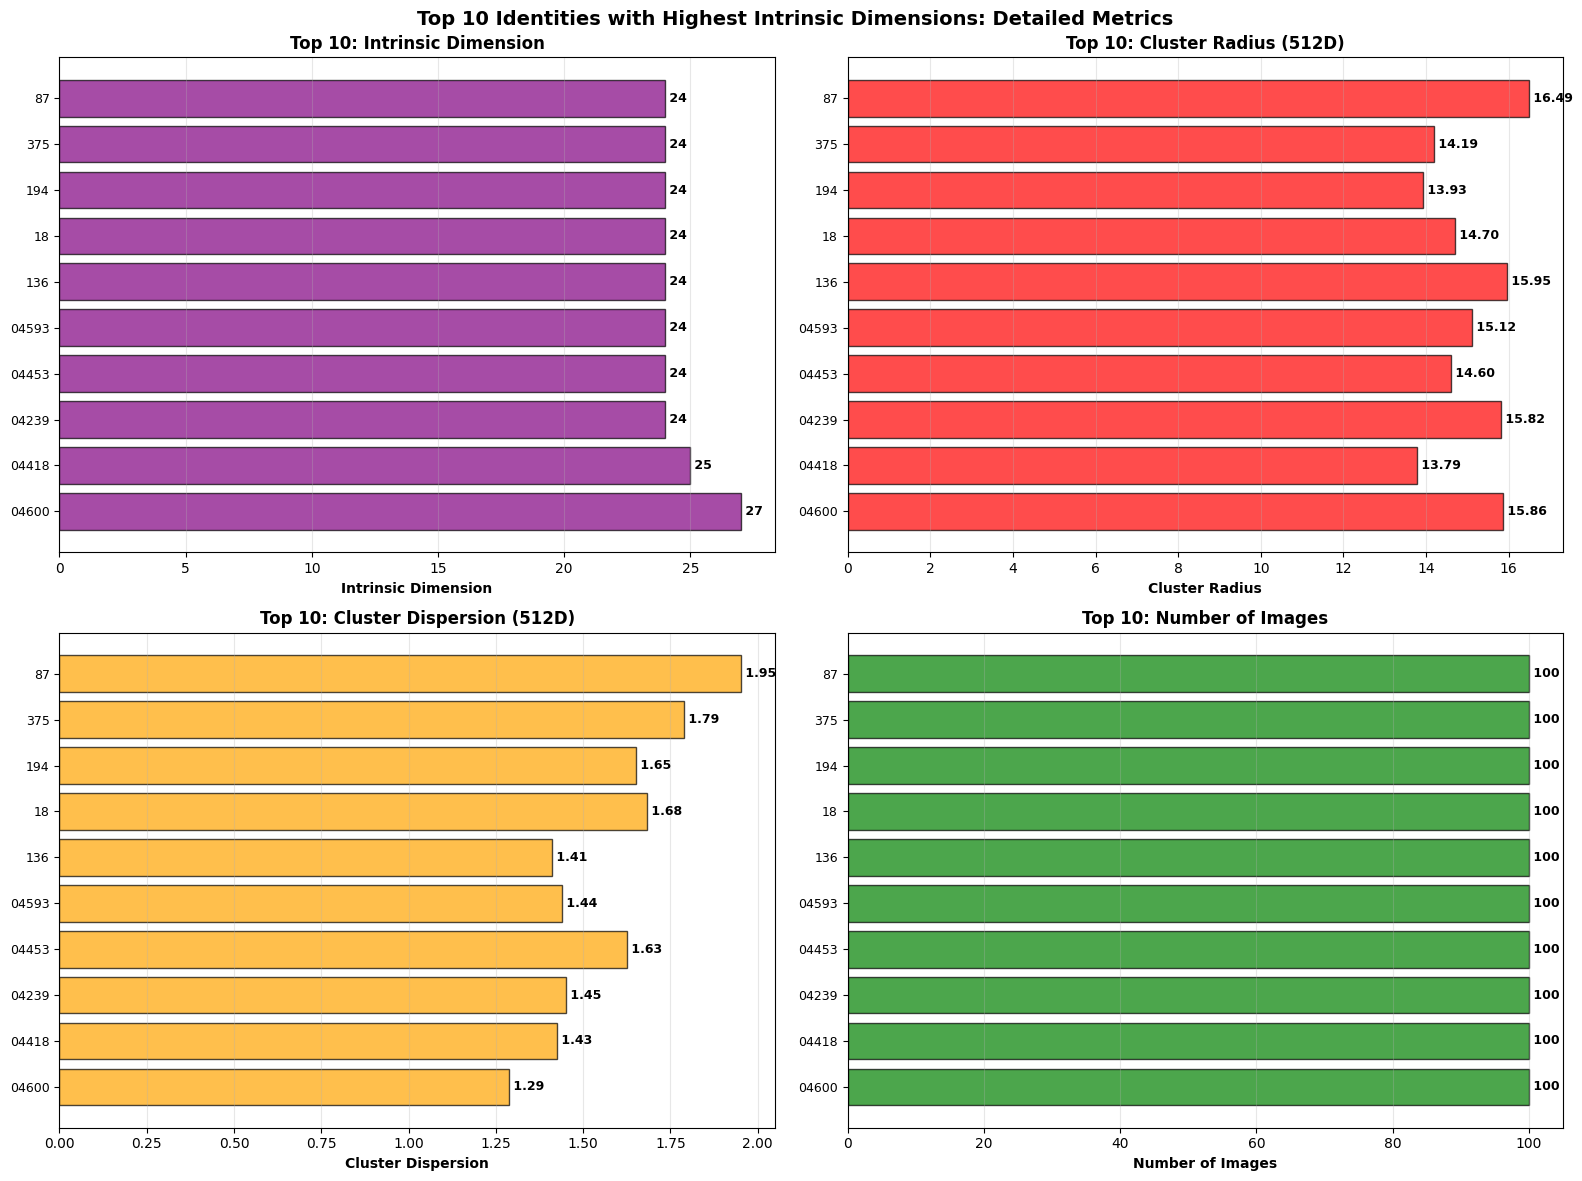

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#intrinsic Dimension
axes[0, 0].barh(range(len(top_10_data)), top_10_data['intrinsic_dimension'], color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_10_data)))
axes[0, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 0].set_xlabel('Intrinsic Dimension', fontweight='bold')
axes[0, 0].set_title('Top 10: Intrinsic Dimension', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['intrinsic_dimension']):
    axes[0, 0].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#radius
axes[0, 1].barh(range(len(top_10_data)), top_10_data['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10_data)))
axes[0, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 1].set_xlabel('Cluster Radius', fontweight='bold')
axes[0, 1].set_title('Top 10: Cluster Radius (512D)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#dispersion
axes[1, 0].barh(range(len(top_10_data)), top_10_data['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_data)))
axes[1, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 0].set_xlabel('Cluster Dispersion', fontweight='bold')
axes[1, 0].set_title('Top 10: Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#number of Images
axes[1, 1].barh(range(len(top_10_data)), top_10_data['num_images'], color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_10_data)))
axes[1, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Top 10: Number of Images', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Top 10 Identities with Highest Intrinsic Dimensions: Detailed Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

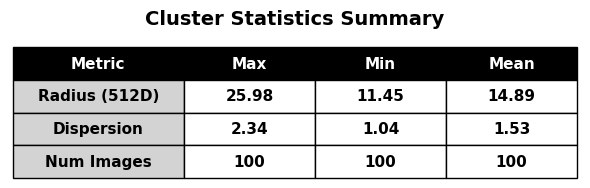

In [37]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
summary_table_data = [
    ['Metric', 'Max', 'Min', 'Mean'],
    ['Radius (512D)', f"{merged_df['radius'].max():.2f}", f"{merged_df['radius'].min():.2f}", f"{merged_df['radius'].mean():.2f}"],
    ['Dispersion', f"{merged_df['dispersion'].max():.2f}", f"{merged_df['dispersion'].min():.2f}", f"{merged_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(merged_df['num_images'].max())}", f"{int(merged_df['num_images'].min())}", f"{int(merged_df['num_images'].mean())}"]
]
table1 = ax.table(cellText=summary_table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.23, 0.23, 0.23])
table1.auto_set_font_size(False)
table1.set_fontsize(11)
table1.scale(1, 2.5)
for i in range(4):
    table1[(0, i)].set_facecolor('black')
    table1[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4):
    table1[(i, 0)].set_facecolor('#D3D3D3')
    table1[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table1[(i, j)].set_facecolor('white')
        table1[(i, j)].set_text_props(weight='bold')
plt.title('Cluster Statistics Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

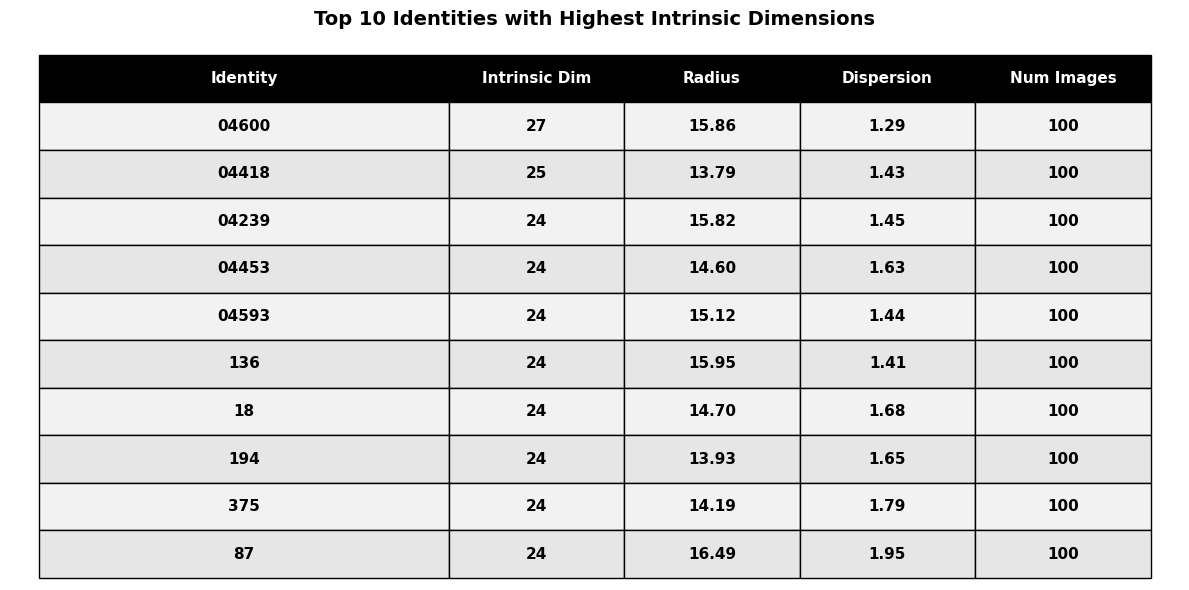

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = [['Identity', 'Intrinsic Dim', 'Radius', 'Dispersion', 'Num Images']]
for identity, row in top_10_data.iterrows():
    table_data.append([
        identity,
        f"{int(row['intrinsic_dimension'])}",
        f"{row['radius']:.2f}",
        f"{row['dispersion']:.2f}",
        f"{int(row['num_images'])}"
    ])
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(5):
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')
        table[(i, j)].set_text_props(weight='bold')
plt.title('Top 10 Identities with Highest Intrinsic Dimensions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 12. Scatter Plot: Radius and Number of Images


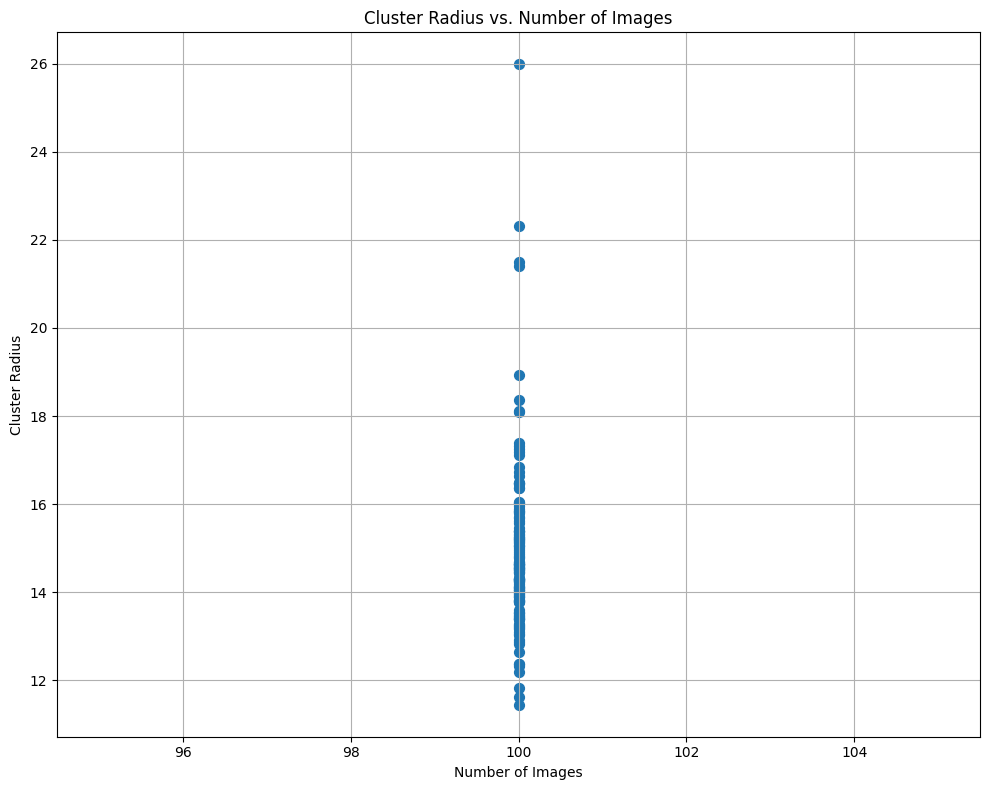

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['num_images'], merged_df['radius'], s=50)
plt.title('Cluster Radius vs. Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Cluster Radius')
plt.grid(True)
plt.tight_layout()
plt.show()

No strong linear correlation between them


Even with few images some identites have very consistent embeddings, while others can be quite incosistent

